# Assignment 2 - Dimensionality Reduction Methods

# Import Libraries 


In [ ]:
# Ignoring unnecessory warnings
import warnings
warnings.filterwarnings("ignore")  
# For image files manipulation
import cv2
from PIL import Image
# For data vizualization 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
# For large and multi-dimensional arrays
import numpy as np
# For data manipulation
import pandas as pd
# Machine Learning Library
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
# Communicating with Operating System functionalities
import os 

# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Question 1: Preprocessing, dimensionality reduction and visualization and image sorting 

## I.

Define a coding for labels, such that each season will correspond to a unique integer 

In [ ]:
season_to_label = dict()
season_to_label['W'] = 0
season_to_label['F'] = 1
season_to_label['S'] = 2

In [ ]:
def loadimages(path):
  """
  @path: 
    the path in which the image folder is located

  @returns: 
    tuple (data, labels) where data represents 
    each image as a vector column of dimension 30000 
    and labels correspond to a single integer for 
    each data entry.
  """
  data = np.zeros(shape=(7500, 30))
  labels = np.zeros(shape=(30,))
  for i, filename in enumerate(os.listdir(path)):
      if filename.endswith(".jpg"): 
          filepath = os.path.join(path, filename)
          oriimg = cv2.imread(filepath, cv2.IMREAD_COLOR)
          image = cv2.resize(oriimg, (50, 50), interpolation=cv2.INTER_NEAREST)
          data[:, i] = image.ravel()
          labels[i] = season_to_label[filename[0]]
      else:
          continue
  return data, labels

In [ ]:
path = input("Insert path to images folder: ")
data, labels = loadimages(path)
print("Data shape: ", data.shape)
print("Labels shape: ", labels.shape)

Insert path to images folder: /content/drive/MyDrive/DI/6th Semester/ML/Assignments/Assignment-2/images
Data shape:  (7500, 30)
Labels shape:  (30,)


## II.

In [ ]:
def ComputePCA(X, num_components):
  # Subtract the mean of each variable
  X_meaned = X - X.mean(axis=0)     
  # Calculate the Covariance Matrix
  cov_mat = np.cov(X_meaned , rowvar = False)
  # Compute the Eigenvalues and Eigenvectors of Covariance matrix
  eigen_values, eigen_vectors = np.linalg.eigh(cov_mat)
  # Sort Eigenvalues and Eigenvectors in descending order
  sorted_index = np.argsort(eigen_values)[::-1]
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]
  # Select a subset from the rearranged Eigenvalue matrix
  eigenvector_subset = sorted_eigenvectors[:,0:num_components]
  # Transform the data 
  X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose()).transpose()
  return X_reduced

In [ ]:
def PCA_ImageSpaceVisualization(X):
  """
  Images are displayed in the two-dimensional space 
  resulting from the projection of the data in the first 
  two principal components.

  @args X: 
    image data numpy array of shape (dimensions, samples)
  """
  pca_data = ComputePCA(X.T, num_components=2)
  
  x_coords = [item[0] for item in pca_data]
  y_coords = [item[1] for item in pca_data]

  fig = plt.figure(figsize = (24,12))
  ax = fig.add_subplot(1,1,1) 
  ax.scatter(x_coords, y_coords)
  plt.axis('off')
  
  for i, (x0, y0) in enumerate(zip(x_coords, y_coords)):
      img = np.asarray(np.matrix(X[:, i]), dtype="uint8").reshape((50, 50, 3))
      RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      ab = AnnotationBbox(OffsetImage(RGB_img), (x0, y0), frameon=True)
      ax.add_artist(ab)

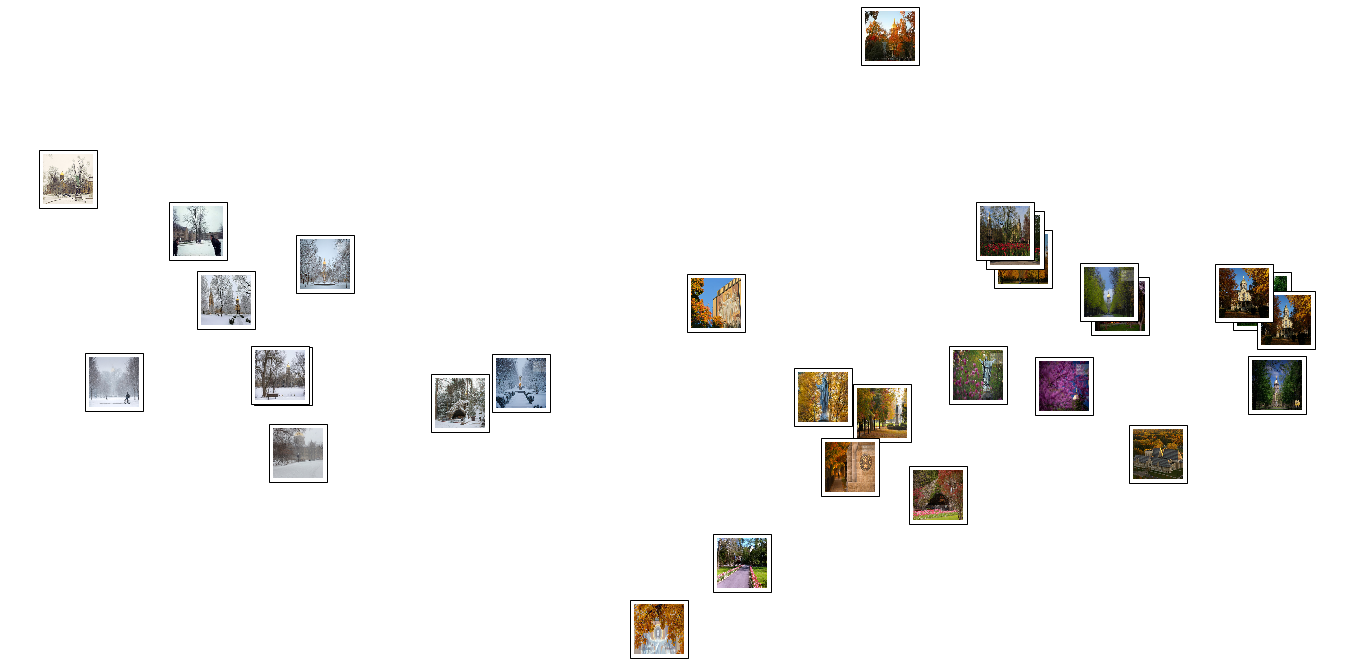

In [ ]:
PCA_ImageSpaceVisualization(data)

## III.


**What does it mean when images are close to this two-dimensional space shown in the above plot? What does it mean when images are far apart? Can we generalize these conclusions about the original image space which is very large?**

According to the above data, what we perceive, when the images/points of the graph are close, is that the RGB pixel values of each image, during the dimensionality reduction and transformation into eigenvalues, remain close given a metric. This function of the PCA model results in a categorization of the images, by comparing their similarity. In this way we see in the above plots that the images are partially categorized according to the season (and more specifically in terms of colors). Finally, specifically in the PCA execution steps, what happens is that the points corresponding to the nearby images have a positive correlation with each other (When one increases or decreases, there is a corresponding behavior in the other).

When the images are far apart it means that the points of the covariance matrix that correspond to the images have a negative covariance with each other. That is, when the value of one increases, the other decreases (or even the other way around) as a result they move away. Then, by selecting the larger eigenvectors and drawing in the diagram, we observe that the distance between them, which in this example is the difference of colors and therefore the seasons.

In the high dimensional space the data can not be displayed on a two-dimensional graph to decide whether to categorize or not. Through PCA the data of each photo (50x50x3 corresponds to a vector of dimension 7500) gradually end up being mirrored in two dimensions. So yes the conclusions apply to the high dimensional data but it can not be understood by us. 

## IV.

**Do the images corresponding to one of the seasons tend to be grouped closer than the others? Why is this happening?**

To answer this question, it is enough to think about when two images are grouped close together. Two images are grouped close together when the data produced by the PCA are close by. As mentioned above, the original high dimensional space of the images should be close as well.

This happens when the images have similar colors, that means the numerical value of their pixels has the same order of magnitude. Thus, images that belong to a specific season tend to cover a common range of colors and as a result their pixels have relatively similar values. 

## V.

**Compare the classification accuracy of the nearest neighbor classifier (1-NN) and the classification of three nearest neighbors (3-NN) to the problem of recognizing the season in which an image was recorded. In other words, compare the performance (in terms of classification accuracy) of the above classifiers in classifying the image data into winter, spring and autumn categories.**


### V.1

**Use 5-fold cross validation and report the average classification accuracy for both classifiers for both the original high-dimensional data and the low-dimensional characteristics that have been exported using PCA.**

In [ ]:
# Define Classifiers
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_3 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
# Execute 5-fold cross validation using knn (k=1) classifier
knn_1_original_scores = cross_validate(knn_1, data.T, labels, cv=5, 
                                       scoring='accuracy',
                                       return_train_score=True)

In [ ]:
knn_1_original_scores

{'fit_time': array([0.00430369, 0.00277209, 0.00281858, 0.00291109, 0.00278044]),
 'score_time': array([0.00395107, 0.00383234, 0.00388908, 0.00377345, 0.00436807]),
 'test_score': array([0.83333333, 1.        , 1.        , 0.66666667, 0.66666667]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
print('Average accuracy score using 1-NN Classifier trained on original data: {}'.format(knn_1_original_scores['test_score'].mean()))

Average accuracy score using 1-NN Classifier trained on original data: 0.8333333333333334


In [ ]:
# Execute 5-fold cross validation using knn (k=3) classifier
knn_3_original_scores = cross_validate(knn_3, data.T, labels, cv=5, 
                                       scoring='accuracy',
                                       return_train_score=True)

In [ ]:
knn_3_original_scores

{'fit_time': array([0.00507498, 0.00275946, 0.00275612, 0.00268269, 0.00267339]),
 'score_time': array([0.00734425, 0.00412297, 0.00383544, 0.00366545, 0.00365615]),
 'test_score': array([0.66666667, 0.83333333, 0.83333333, 0.66666667, 0.66666667]),
 'train_score': array([0.91666667, 0.91666667, 0.83333333, 0.875     , 0.91666667])}

In [ ]:
print('Average accuracy score using 3-NN Classifier trained on original data: {}'.format(knn_3_original_scores['test_score'].mean()))

Average accuracy score using 3-NN Classifier trained on original data: 0.7333333333333333


We will repeat the same steps for both classifiers now using the low-dimensional data we computed via PCA. The dimensionality of the features variables that we will export using PCA will be 15. Below in question V.2, by examining the cumulative ratio of the explained variance with the number of main components, we explain how this number of components was selected.

In [ ]:
pca_data = PCA(n_components=15, whiten=True).fit_transform(data.T)

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=1)
knn_3 = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_1_pca_scores = cross_validate(knn_1, pca_data, labels, cv=5, 
                                  scoring='accuracy',
                                  return_train_score=True)

In [ ]:
knn_1_pca_scores

{'fit_time': array([0.00093246, 0.0028882 , 0.00091529, 0.00076437, 0.00070596]),
 'score_time': array([0.00329542, 0.00194097, 0.00462294, 0.00203323, 0.00909424]),
 'test_score': array([0.5       , 0.5       , 0.66666667, 0.5       , 0.66666667]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [ ]:
print('Average accuracy score using 1-NN Classifier trained on data extracted by performing PCA: {}'.format(knn_1_pca_scores['test_score'].mean()))

Average accuracy score using 1-NN Classifier trained on data extracted by performing PCA: 0.5666666666666667


In [ ]:
knn_3_pca_scores = cross_validate(knn_3, pca_data, labels, cv=5, 
                                  scoring='accuracy',
                                  return_train_score=True)

In [ ]:
knn_3_pca_scores

{'fit_time': array([0.00048971, 0.00076485, 0.00080657, 0.00074983, 0.00045681]),
 'score_time': array([0.00118971, 0.00372505, 0.00381398, 0.00129771, 0.00107598]),
 'test_score': array([0.66666667, 0.5       , 0.5       , 0.33333333, 0.5       ]),
 'train_score': array([0.70833333, 0.625     , 0.75      , 0.70833333, 0.66666667])}

In [ ]:
print('Average accuracy score using 3-NN Classifier trained on data extracted by performing PCA: {}'.format(knn_3_pca_scores['test_score'].mean()))

Average accuracy score using 3-NN Classifier trained on data extracted by performing PCA: 0.5


**Final results**

In [ ]:
summary_results = pd.DataFrame(columns=['Classifier', 'Original data', 'PCA data', 'Average Accuracy'])
summary_results.loc[len(summary_results)] = ['1-NN', knn_1_original_scores['test_score'].mean(), knn_1_pca_scores['test_score'].mean(), (knn_1_original_scores['test_score'].mean() + knn_1_pca_scores['test_score'].mean()) / 2]
summary_results.loc[len(summary_results)] = ['3-NN', knn_3_original_scores['test_score'].mean(), knn_3_pca_scores['test_score'].mean(), (knn_3_original_scores['test_score'].mean() + knn_3_pca_scores['test_score'].mean()) / 2]
print(summary_results)

  Classifier  Original data  PCA data  Average Accuracy
0       1-NN       0.833333  0.566667          0.700000
1       3-NN       0.733333  0.500000          0.616667


### V.2

**How do we determine the dimension of the features that you will export through PCA?**

To determine the dimension of the features that we will export through PCA we will examine the cumulative ratio of the explained variance in relation to the number of main components

In [ ]:
# Compute a PCA 
n_components = 30 ## how may componets to compute
pca = PCA(n_components=n_components, whiten=True).fit(data.T)

[0.44875359 0.09174614 0.05850803 0.04736781 0.0404097  0.03315796
 0.02850695 0.02564724 0.02081042 0.0187151 ]


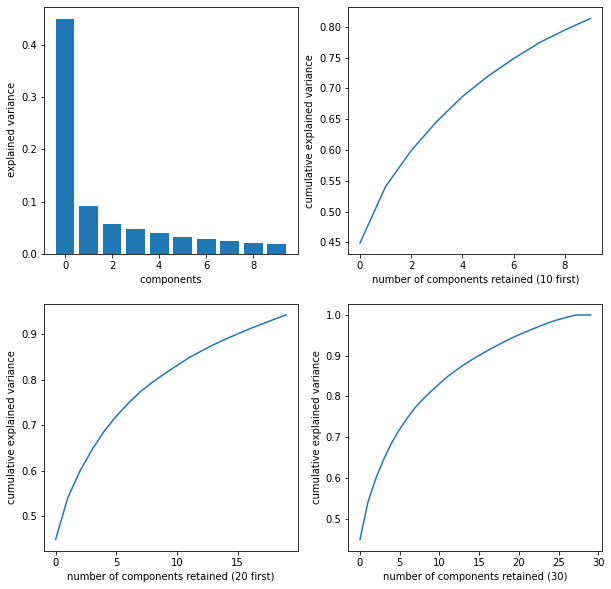

In [ ]:
print (pca.explained_variance_ratio_[:10])

cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 10))
numOfComp=10
plt.subplot(2, 2, 1)
plt.bar(range(numOfComp),pca.explained_variance_ratio_[:numOfComp])
plt.xlabel(' components ')
plt.ylabel(' explained variance');


plt.subplot(2, 2, 2)
plt.plot(cumExplainedVar[:10])
plt.xlabel('number of components retained (10 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 3)
plt.plot(cumExplainedVar[:20])
plt.xlabel('number of components retained (20 first)')
plt.ylabel('cumulative explained variance');

plt.subplot(2, 2, 4)
plt.plot(cumExplainedVar)
plt.xlabel('number of components retained (30)')
plt.ylabel('cumulative explained variance');

plt.show()

We observe that the first two components explain about 60% of the variability of our data, while for 90% we need about 15 components.

# Question 2: Regularized non-negative matrix factorization

## Problem definition

Let the following optimization problem for regularized non-negative matrix factorization (regNMF): 

$\min\limits_{A, B}\lVert X - AB \rVert_F^{2} + λ \lVert A \rVert_F^{2}$, s.t. $A \geq 0, B \geq 0$.

The problem obviously does not have a solution in closed form and therefore must be solved iteratevaly.



## I. 

Let 
$$
\begin{align}
l(A, B) &= \lVert X - AB \rVert_F^2 + λ \lVert A \rVert_F^2\\
&= Tr[(X-AB)^T(X-AB)] + λ Tr(A^TA) \\
&= Tr(X^TX - X^TAB - B^TA^TX + B^TA^TAB) + λ Tr(A^TA) \\
&= Tr(X^TX) - Tr(X^TAB) - Tr(B^TA^TX) + Tr(B^TA^TAB) + λ Tr(A^TA)
\end{align}
$$ \

In order to optimize the aformentioned problem, firstly we are going to initialize the unknown variables $A$ and $B$ with random non-negative values. After that, we are going to apply gradient descent steps (until convergence) as follows:

$A_{[t+1]} \leftarrow A_{[t]} - \eta_A \cdot \nabla_A l(A_{[t]},B)$ \
$B_{[t+1]} \leftarrow B_{[t]} - \eta_B \cdot \nabla_B l(A,B_{[t]})$ \
$t \leftarrow t + 1$

Unfortunately, these multiplicative update rules do not guarantee that random variables $A$ and $B$ won't get negative values! But, we know that each number can be written as the difference of non-negative numbers. \

$\nabla_A l(A,B) = \nabla_A^{+} l(A,B) - \nabla_A^{-} l(A,B) $ \
$\nabla_B l(A,B) = \nabla_B^{+} l(A,B) - \nabla_B^{-} l(A,B) $

The learning rates are defined in such a way that there is no subtraction in the update rules. Thus if we set them to: \
$\eta_A = \frac{A} {\nabla_A^{+} l(A,B)}$ \
$\eta_B = \frac{B} {\nabla_B^{+} l(A,B)}$

Then, the multiplicative update rules can be written in the form of:

$A = A - \eta_A * \nabla_A l(A,B) = A - \frac{A} {\nabla_A^{+} l(A,B)} * \nabla_A l(A,B) = A * \frac{\nabla_A^{-} l(A,B)} {\nabla_A^{+} l(A,B)}$ \
$B = B - \eta_B * \nabla_B l(A,B) = B - \frac{B} {\nabla_B^{+} l(A,B)} * \nabla_B l(A,B) = B * \frac{\nabla_B^{-} l(A,B)} {\nabla_B^{+} l(A,B)}$ 

Thus, to solve the given problem, we need the derivative of $l(A,B)$ w.r.t $A$ and $B$.\

The derivative of each term with respect to $A$:\
$\nabla_A Tr(X^TX) = 0$ \
$\nabla_A Tr(X^TAB) = \nabla_A Tr(BX^TA) = (BX^T)^T = XB^T 
\;\;\;\;\;\;\;\;\;\; \scriptsize \left [ \nabla_X Tr(AX) = A^T \right ] $ \
$\nabla_A Tr(B^TA^TX) = \nabla_A Tr(XB^TA^T) = XB^T 
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \scriptsize \left [ \nabla_X Tr(X^TA) = A \right ] $ \
$\nabla_A Tr(B^TA^TAB) = ABB^T + ABB^T = 2ABB^T \scriptsize \left [ \nabla_X Tr(B^TX^TCXB) = C^TXBB^T + CXBB^T, C := I\right ]$ \
$\nabla_A Tr(A^TA) = 2A$

Thus, $\nabla_A l(A,B) = 2 \cdot (ABB^T + λA - XB^T)$

The derivative of each term with respect to $B$:\
$\nabla_B Tr(X^TX) = 0$ \
$\nabla_B Tr(X^TAB) = (X^TA)^T = A^TX \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;  \scriptsize \left [ \nabla_X Tr(AX) = A^T \right ] $ \
$\nabla_B Tr(B^TA^TX) = A^TX \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;  \scriptsize \left [ \nabla_X Tr(X^TA) = A \right ] $ \
$\nabla_B Tr(B^TA^TAB) = A^TAB + A^TAB = 2A^TAB \scriptsize \left [ \nabla_X Tr(B^TX^TCXB) = C^TXBB^T + CXBB^T, C := I\right ]$ \
$\nabla_B Tr(A^TA) = 0$

Thus, $\nabla_B l(A,B) = 2 \cdot (A^TAB - A^TX)$

The constant 2 can be adjusted in the learning rate and thus can be ignored for now. Finally, using the above derivatives the multiplicative update rules are: \

$A = A * \frac{XB^T} {ABB^T + λA}$ \
\
$B = B * \frac{A^TX} {A^TAB}$ \

## II.

Let's implement an iterative algorithm now to solve the above optimization problem using the multiplicative update rules we just found.

In [ ]:
# Input array X construction
d = 500
N = 500
X = np.abs(np.random.random((d,N)))
print(X)
print(X.shape)

[[0.07179519 0.22290953 0.83066265 ... 0.80839928 0.53882576 0.42069335]
 [0.6209908  0.26911675 0.76259141 ... 0.58097322 0.48197768 0.16693275]
 [0.30851247 0.11053569 0.5158498  ... 0.38300604 0.19687374 0.2845089 ]
 ...
 [0.13953947 0.61276572 0.80667782 ... 0.62851592 0.46281176 0.3732925 ]
 [0.72404753 0.99181289 0.30750117 ... 0.748484   0.47442707 0.12006568]
 [0.15096118 0.35222669 0.10232251 ... 0.62387464 0.19051506 0.82436874]]
(500, 500)


In [ ]:
# Algorithm parameters
epsilons = [0.1, 0.01, 0.001]
ks = [5, 10, 50]
l = 0.5

In [ ]:
# DataFrame to export results from each experiment 
results = pd.DataFrame(columns=['Iterations', 'ε', 'k', 'Reconstruction error'])

In [ ]:
# Implementation of the iterative algorithm 
import numpy.linalg as LA

def Update_A(X, A, B, k, Lambda):
  numerator = np.matmul(X, B.T)
  denominator = A.dot(B.dot(B.T)) + (Lambda*A)
  tempA = np.array(A)
  tempA *= numerator
  tempA /= denominator
  return tempA

def Update_B(X, A, B, k, Lambda):
  numerator = np.matmul(A.T, X)
  denominator = A.T.dot(A.dot(B))
  tempB = np.array(B)
  tempB *= numerator
  tempB /= denominator
  return tempB

def Reconstruction_Error(X, A, B):
  numerator = LA.norm(X-A.dot(B), ord='fro')**2
  denominator = LA.norm(X, ord='fro')**2
  recontruction_error = numerator/denominator 
  return recontruction_error

def RegNMF(X, k, Lambda, epsilon, max_iter=500):
  error_list = []
  max_iters = 500
  d, N = X.shape
  
  # Initialazation of A and B matrix with positive random numbers 
  A = np.abs(np.random.random((d,k)))
  B = np.abs(np.random.random((k,N)))
  
  iteration = 0  
  
  while True:
    # prevA and prevB to hold into variables the matrices in previous iteration
    prevB = np.array(B)
    prevA = np.array(A)
    
    # Update steps for A and B
    B = Update_B(X, prevA, prevB, k, Lambda)
    A = Update_A(X, prevA, B, k, Lambda)
    
    iteration += 1
    error_list.append(Reconstruction_Error(X, prevA, prevB) - Reconstruction_Error(X, A, B))
    
    # Stop algorithm when reaching to max_iters or reconstruction is less or equal than epsilon
    if iteration==max_iters or (Reconstruction_Error(X, prevA, prevB) - Reconstruction_Error(X, A, B)) <= epsilon:
      break
          
  return (A, B, iteration, error_list)

In [ ]:
# Run the different experiments 
for e in epsilons:
  for k in ks:
    A, B, iterations, error_list = RegNMF(X, k, l, e)
    reconstruction_error = Reconstruction_Error(X, A, B)
    print("Ran RegNMF for ε={}\t k={}\t λ={}\t Reconstrution Error: {}".format(e, k, l, reconstruction_error))
    results.loc[len(results)] = [int(iterations), e, k, reconstruction_error]

Ran RegNMF for ε=0.1	 k=5	 λ=0.5	 Reconstrution Error: 0.2610017599782243
Ran RegNMF for ε=0.1	 k=10	 λ=0.5	 Reconstrution Error: 0.2551417268272646
Ran RegNMF for ε=0.1	 k=50	 λ=0.5	 Reconstrution Error: 0.25161670302474853
Ran RegNMF for ε=0.01	 k=5	 λ=0.5	 Reconstrution Error: 0.2602846377103043
Ran RegNMF for ε=0.01	 k=10	 λ=0.5	 Reconstrution Error: 0.25547424286034603
Ran RegNMF for ε=0.01	 k=50	 λ=0.5	 Reconstrution Error: 0.2516877142310419
Ran RegNMF for ε=0.001	 k=5	 λ=0.5	 Reconstrution Error: 0.2536750959282361
Ran RegNMF for ε=0.001	 k=10	 λ=0.5	 Reconstrution Error: 0.25320190828454003
Ran RegNMF for ε=0.001	 k=50	 λ=0.5	 Reconstrution Error: 0.24969076517851702


In [ ]:
results

,Iterations,ε,k,Reconstruction error
0,2.0,0.100,5.0,0.261002
1,2.0,0.100,10.0,0.255142
2,2.0,0.100,50.0,0.251617
3,2.0,0.010,5.0,0.260285
4,2.0,0.010,10.0,0.255474
5,2.0,0.010,50.0,0.251688
6,7.0,0.001,5.0,0.253675
7,4.0,0.001,10.0,0.253202
8,4.0,0.001,50.0,0.249691


**Lowest Reconstruction Error based on parameters $ε$ and $k$**

In [ ]:
results.sort_values(by=['Reconstruction error', 'ε', 'k'])

,Iterations,ε,k,Reconstruction error
8,4.0,0.001,50.0,0.249691
2,2.0,0.100,50.0,0.251617
5,2.0,0.010,50.0,0.251688
7,4.0,0.001,10.0,0.253202
6,7.0,0.001,5.0,0.253675
1,2.0,0.100,10.0,0.255142
4,2.0,0.010,10.0,0.255474
3,2.0,0.010,5.0,0.260285
0,2.0,0.100,5.0,0.261002


**Mean Reconstruction Error based on parameters $k$**

In [ ]:
results[['k', 'Reconstruction error']].groupby(by=['k']).mean()

,Reconstruction error
k,
5.0,0.258320
10.0,0.254606
50.0,0.250998


**Mean Reconstruction Error based on parameters $ε$**

In [ ]:
results[['ε', 'Reconstruction error']].groupby(by=['ε']).mean()

,Reconstruction error
ε,
0.001,0.252189
0.010,0.255816
0.100,0.255920


**Plots**

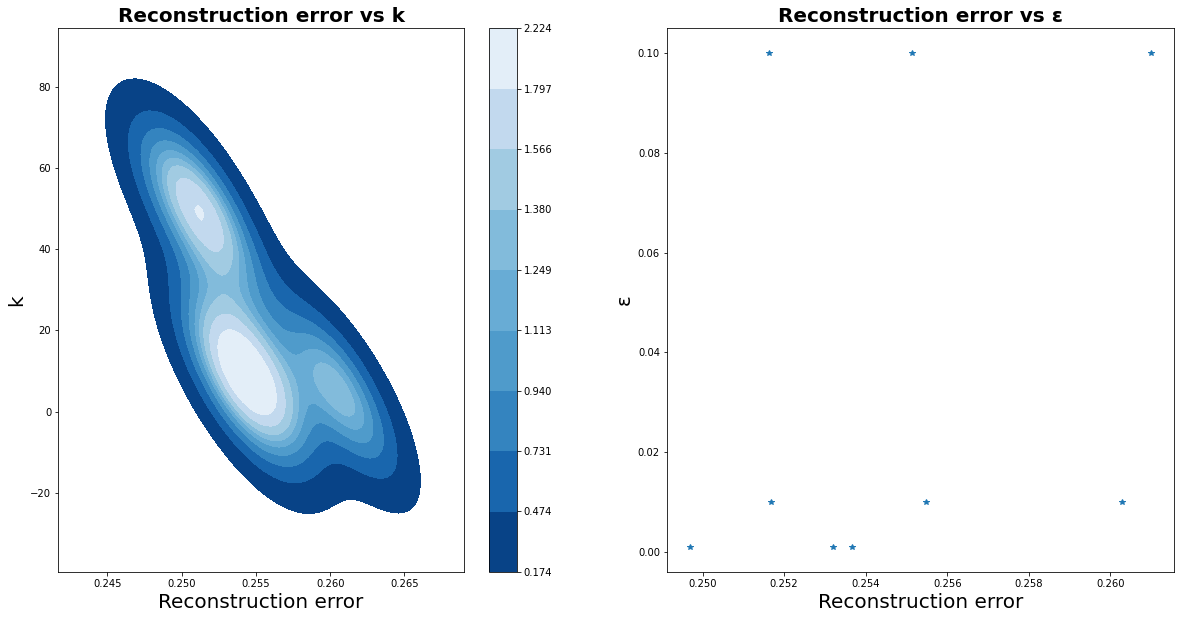

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.kdeplot(data=results['Reconstruction error'], data2=results['k'], cbar=True, cmap="Blues_r", shade=True, bw='silverman', gridsize=100, ax=axs[0])
axs[0].set_xlabel('Reconstruction error', fontsize=20)
axs[0].set_ylabel('k', fontsize=20)
axs[0].set_title('Reconstruction error vs k',fontsize=20,fontweight='bold')
axs[1].plot(results['Reconstruction error'], results['ε'], '*')
axs[1].set_xlabel('Reconstruction error', fontsize=20)
axs[1].set_ylabel('ε', fontsize=20)
axs[1].set_title('Reconstruction error vs ε', fontsize=20, fontweight='bold')
plt.show()

**Study the behavior of the regNMF algorithm with respect to the number of iterations required to converge if $k = 5, 10, 50$ and $ε = 0.1, 0.01, 0.001$.**

For all combinations of the above values ​​of the parameters $ε$ and $k$, we conclude that the number of iterations performed is relatively small and therefore the reconstruction error is relative high. That means that the matrices product $AB$ does not approximate optimally the initial matrix $X$. 


In order to extract more meaningful experimental results, we are going to execute a variety of experiments with lower values for $ε$ and higher values for $k$. Then, by observing the updated Dataframes and plots, we are going to report our final findings. 

In [ ]:
epsilons = [0.1, 0.01, 0.001, 0.0001]
ks = [5, 10, 50, 100, 250, 500]
results = pd.DataFrame(columns=['Iterations', 'ε', 'k', 'Reconstruction error'])

In [ ]:
for e in epsilons:
  for k in ks:
    A, B, iterations, error_list = RegNMF(X, k, l, e)
    reconstruction_error = Reconstruction_Error(X, A, B)
    print("Ran RegNMF for ε={}\t k={}\t λ={}\t Reconstrution Error: {}".format(e, k, l, reconstruction_error))
    results.loc[len(results)] = [int(iterations), e, k, reconstruction_error]

Ran RegNMF for ε=0.1	 k=5	 λ=0.5	 Reconstrution Error: 0.2604204215966077
Ran RegNMF for ε=0.1	 k=10	 λ=0.5	 Reconstrution Error: 0.2554918091761866
Ran RegNMF for ε=0.1	 k=50	 λ=0.5	 Reconstrution Error: 0.25178938614432345
Ran RegNMF for ε=0.1	 k=100	 λ=0.5	 Reconstrution Error: 0.2549180326412395
Ran RegNMF for ε=0.1	 k=250	 λ=0.5	 Reconstrution Error: 0.26526508150666944
Ran RegNMF for ε=0.1	 k=500	 λ=0.5	 Reconstrution Error: 0.27344391395640716
Ran RegNMF for ε=0.01	 k=5	 λ=0.5	 Reconstrution Error: 0.2614241717629209
Ran RegNMF for ε=0.01	 k=10	 λ=0.5	 Reconstrution Error: 0.2553175052589006
Ran RegNMF for ε=0.01	 k=50	 λ=0.5	 Reconstrution Error: 0.25184341300453134
Ran RegNMF for ε=0.01	 k=100	 λ=0.5	 Reconstrution Error: 0.2549904055803196
Ran RegNMF for ε=0.01	 k=250	 λ=0.5	 Reconstrution Error: 0.25716783647483643
Ran RegNMF for ε=0.01	 k=500	 λ=0.5	 Reconstrution Error: 0.25487102214502877
Ran RegNMF for ε=0.001	 k=5	 λ=0.5	 Reconstrution Error: 0.25334769162726667
Ran Reg

In [ ]:
results

,Iterations,ε,k,Reconstruction error
0,2.0,0.1000,5.0,0.260420
1,2.0,0.1000,10.0,0.255492
2,2.0,0.1000,50.0,0.251789
3,2.0,0.1000,100.0,0.254918
4,2.0,0.1000,250.0,0.265265
5,2.0,0.1000,500.0,0.273444
6,2.0,0.0100,5.0,0.261424
7,2.0,0.0100,10.0,0.255318
8,2.0,0.0100,50.0,0.251843
9,2.0,0.0100,100.0,0.254990


In [ ]:
results.sort_values(by=['Reconstruction error', 'ε', 'k'])

,Iterations,ε,k,Reconstruction error
23,260.0,0.0001,500.0,0.043567
22,183.0,0.0001,250.0,0.112184
21,154.0,0.0001,100.0,0.167320
20,132.0,0.0001,50.0,0.198811
19,59.0,0.0001,10.0,0.240597
18,31.0,0.0001,5.0,0.247138
16,8.0,0.0010,250.0,0.247717
17,8.0,0.0010,500.0,0.248235
15,6.0,0.0010,100.0,0.248532
14,4.0,0.0010,50.0,0.249780


In [ ]:
results[['k', 'Reconstruction error']].groupby(by=['k']).mean()

,Reconstruction error
k,
5.0,0.255583
10.0,0.251136
50.0,0.238056
100.0,0.231440
250.0,0.220583
500.0,0.205029


In [ ]:
results[['ε', 'Reconstruction error']].groupby(by=['ε']).mean()

,Reconstruction error
ε,
0.0001,0.168270
0.0010,0.250124
0.0100,0.255936
0.1000,0.260221


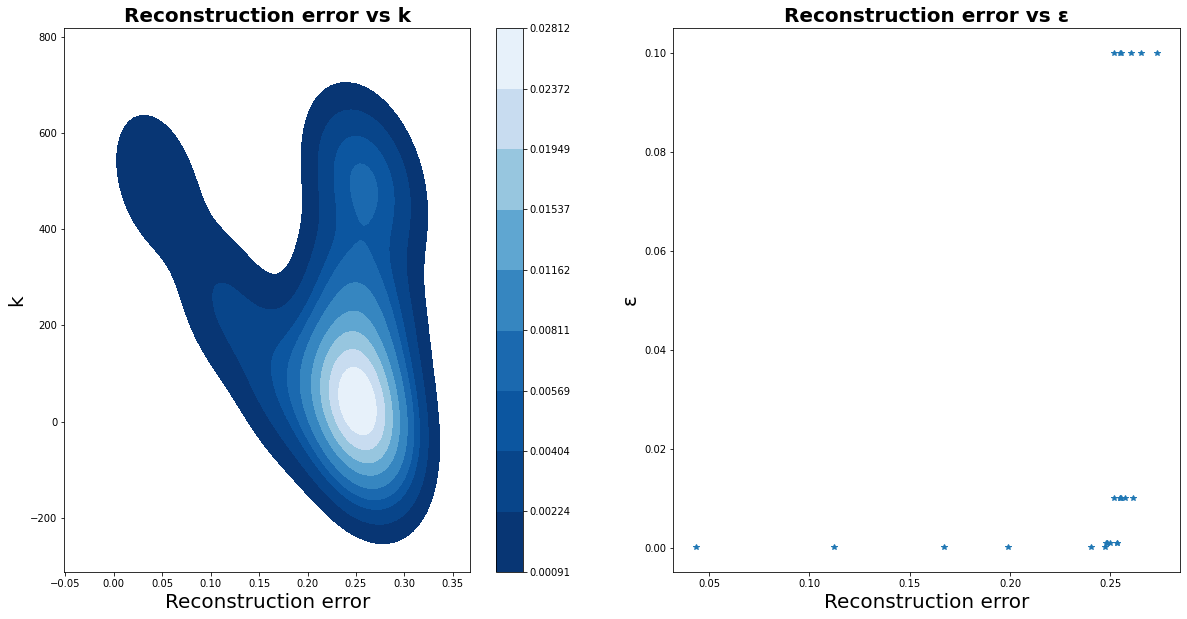

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
sns.kdeplot(data=results['Reconstruction error'], data2=results['k'], cbar=True, cmap="Blues_r", shade=True, bw='silverman', gridsize=100, ax=axs[0])
axs[0].set_xlabel('Reconstruction error', fontsize=20)
axs[0].set_ylabel('k', fontsize=20)
axs[0].set_title('Reconstruction error vs k',fontsize=20,fontweight='bold')
axs[1].plot(results['Reconstruction error'], results['ε'], '*')
axs[1].set_xlabel('Reconstruction error', fontsize=20)
axs[1].set_ylabel('ε', fontsize=20)
axs[1].set_title('Reconstruction error vs ε', fontsize=20, fontweight='bold')
plt.show()

**Experimental study according to measurements and diagrams**




1. As parameter $k$ increases, the reconstruction error between the initial matrix $X$ and the matrix product $AB$ tends to decrease.
2. The total number of iterations increases as the termination threshold $ε$ decreases. Therefore, when $k$ is 500 (i.e. as much as the one dimension of the original matrix $X$), we observe that matrices $X$ and $AB$ are very close to each other (successful factorization). 
3. By observing the heatmap, we notice that the reconstruction error for most factorized matrices is close to 0.25. This happens even in changes of the parameters $k$ and $ε$.



**What are your conclusions about the behavior of the algorithm for different values ​​of $k$ and epsilon ($ε$)?**



1. As the $ε$ decreases more iterations occur, resulting in a greater approximation of the $AB$ product to the initial matrix $X$.
2. Increasing parameter $k$ make sense to improve convergence, as the higher the rank (and the selected components), the greater the amount of information retained. This is confirmed by measurements as we see that in several cases convergence improves when $k$ increases.


